# Giotto-Time

Welcome to `giotto-time`, a Python library for time series forecasting!

Let's start with an example.

## First example

### Ingredients

These are the main ingredients of `giotto-time`:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gtime.preprocessing import TimeSeriesPreparation
from gtime.compose import FeatureCreation
from gtime.feature_extraction import Shift, MovingAverage
from gtime.feature_generation import PeriodicSeasonal, Constant, Calendar
from gtime.model_selection import horizon_shift, FeatureSplitter
from gtime.forecasting import GAR

- `TimeSeriesPreparation`: checks the input format of the time series and converts it to the expected format
- `FeatureCreation`: scikit-learn's `ColumnTransformer` wrapper that returns DataFrame
- `Shift`, `MovingAverage`: create the desired features on the time series for the forecasting
- `FeatureSplitter`: prepares the custom `giotto-time` train-test matrices that are used in the model
- `GAR`: Generalized Auto Regressive model, scikit-learn's `MultiOutputRegressor` wrapper. This is the only time series forecasting model available for the first release

We also need a scikit-learn regression model. We go for a standard `LinearRegression` for this example.

In [2]:
from sklearn.linear_model import LinearRegression

### Data

We use the `pandas.testing` module to create a testing time series

In [3]:
def test_time_series():
    from pandas.util import testing as testing

    testing.N, testing.K = 500, 1
    df = testing.makeTimeDataFrame( freq="D" )
    return df

In [4]:
time_series = test_time_series()
print(f'Time series shape: {time_series.shape}')
print(f'Time series index type: {time_series.index.__class__}')

Time series shape: (30, 4)
Time series index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


/Users/stefano/anaconda3/envs/giotto-time/lib/python3.7/site-packages/pandas/util/__init__.py:12: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing


### Time Series Preparation

The input time series has to be a `DataFrame` with a `PeriodIndex`. Use the provided class `TimeSeriesPreparation` to convert the time series into this format.

In [5]:
time_series_preparation = TimeSeriesPreparation()

In [6]:
period_index_time_series = time_series_preparation.transform(time_series)

In [7]:
print(f'Time series index type after the preprocessing: {period_index_time_series.index.__class__}')

Time series index type after the preprocessing: <class 'pandas.core.indexes.period.PeriodIndex'>


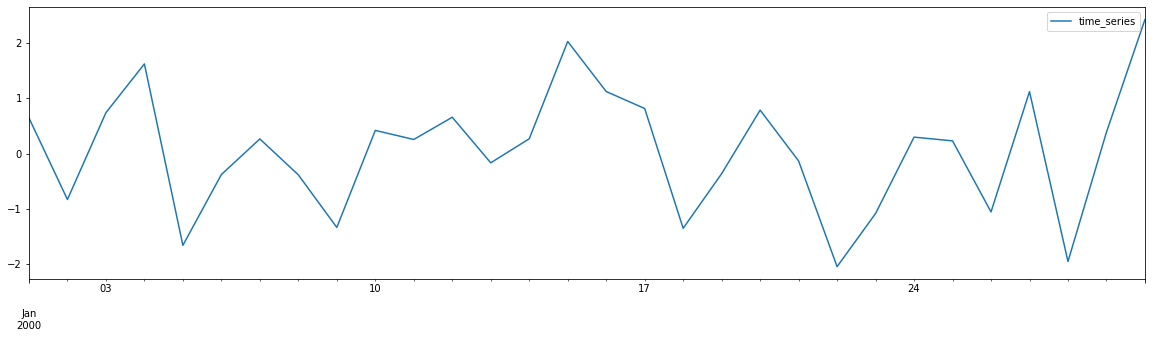

In [8]:
period_index_time_series.plot(figsize=(20, 5))
plt.show()

### Feature extraction

The feature extraction part is aimed at providing a scikit-learn paradigm with a time-series forecasting perspective
Our `DataFrameTransformer` inherits from scikit-learn's `ColumnTransformer`, it will create a feature DataFrame with the provided Transformers.

For simplicity we will create only `Shift` and `MovingAverage` features. 

`Shift` provides a temporal shift of the time series. Adding two `Shift` features (by 0 and 1) is equivalent to an `AR(2)` model. 

Since the `DataFrameTransformer` is a `ColumnTransformer` wrapper, you can easily include features from `scikit-learn`, `tsfresh`, topological features from `giotto-tda` (\o/) or your own custom features.

In [9]:
cal = Calendar(
    start_date="ignored",
    end_date="ignored",
    region="america",
    country="Brazil",
    kernel=np.array([0, 1]),
)
# New API 
dft = FeatureCreation(
    [('s0', Shift(0), ['time_series']), 
     ('s1', Shift(1), ['time_series']),
     ('ma3', MovingAverage(window_size=3), ['time_series']),
     # ('cal', cal, ['time_series']),
     # ('ct', Constant(2), ['time_series']),
    ])

In [10]:
X = dft.fit_transform(period_index_time_series)
X.head(6)

,s0__time_series__Shift,s1__time_series__Shift,ma3__time_series__MovingAverage
2000-01-01,0.645392,NaN,NaN
2000-01-02,-0.827492,0.645392,NaN
2000-01-03,0.739830,-0.827492,0.185910
2000-01-04,1.620371,0.739830,0.510903
2000-01-05,-1.655263,1.620371,0.234979
2000-01-06,-0.377386,-1.655263,-0.137426


In [11]:
y = horizon_shift(period_index_time_series, horizon=3)
y.head()

,y_1,y_2,y_3
2000-01-01,-0.827492,0.739830,1.620371
2000-01-02,0.739830,1.620371,-1.655263
2000-01-03,1.620371,-1.655263,-0.377386
2000-01-04,-1.655263,-0.377386,0.265815
2000-01-05,-0.377386,0.265815,-0.382270


### Train-Test split

We use `FeatureSplitter` to split the matrices X and y in train and test. 

In [12]:
feature_splitter = FeatureSplitter()

In [13]:
X_train, y_train, X_test, y_test = feature_splitter.transform(X, y)

In [14]:
X_train.tail()

,s0__time_series__Shift,s1__time_series__Shift,ma3__time_series__MovingAverage
2000-01-23,-1.080190,-2.039976,-1.083886
2000-01-24,0.298441,-1.080190,-0.940575
2000-01-25,0.231146,0.298441,-0.183534
2000-01-26,-1.051813,0.231146,-0.174076
2000-01-27,1.120227,-1.051813,0.099853


In [15]:
X_test

,s0__time_series__Shift,s1__time_series__Shift,ma3__time_series__MovingAverage
2000-01-28,-1.947150,1.120227,-0.626245
2000-01-29,0.388478,-1.947150,-0.146148
2000-01-30,2.421464,0.388478,0.287597


In [16]:
y_train.tail()

,y_1,y_2,y_3
2000-01-23,0.298441,0.231146,-1.051813
2000-01-24,0.231146,-1.051813,1.120227
2000-01-25,-1.051813,1.120227,-1.947150
2000-01-26,1.120227,-1.947150,0.388478
2000-01-27,-1.947150,0.388478,2.421464


In [17]:
y_test

,y_1,y_2,y_3
2000-01-28,0.388478,2.421464,NaN
2000-01-29,2.421464,NaN,NaN
2000-01-30,NaN,NaN,NaN


### Training

We rewrapped scikit-learn's `MultiOutputRegressor` as `GAR` (Generalized Auto Regressive) model to better fit time series forecasting frameworks.

The traditional *AR* model is equivalent to the `GAR` model that uses only `Shift` columns in the `X` matrix.
`GAR` supports all the features compatible with the feature extraction step.

*AR*: https://en.wikipedia.org/wiki/Autoregressive_model

In [18]:
lr = LinearRegression()
model = GAR(lr)

In [19]:
model = model.fit(X_train, y_train)

### Forecasting

We forecast 3 time steps of the time series (we set this parameter in `horizon_shift` method).

The format of the output is the following:
- the index is the step at which the prediction is made.
- the column `y_1` is the prediction one time step after and so on for `y_2` and `y_3`

In [20]:
predictions = model.predict(X_test)

In [21]:
predictions

,y_1,y_2,y_3
2000-01-28,-0.674776,-0.173466,0.083238
2000-01-29,0.576842,0.050310,-0.250337
2000-01-30,-0.291352,-0.738095,0.279996
